# HR-аналитика

## Введение

### Описание проекта

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.

### Цель проекта

Построить модели позволяющие предсказывать уровень удовлетворённости сотрудников и их отток.

### Описание исследования

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён.

Почему бизнесу это важно: удовлетворённость работой напрямую влияет на отток сотрудников. А предсказание оттока — одна из важнейших задач HR-аналитиков. Внезапные увольнения несут в себе риски для компании, особенно если уходит важный сотрудник.

### Задачи исследования

- Первая задача - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 
- Вторая - построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.

### Исходные данные

Для предсказания **уровня удовлетворённости** сотрудника заказчик предоставил данные с признаками:
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак.

Для **предсказания увольнения** сотрудника из компании используются те же входные признаки, что и в предыдущей задаче. 
Однако целевой признак отличается: 
- это `quit` — увольнение сотрудника из компании.

###  Используемые библиотеки

In [1]:
import os # для проверки наличия директорий при загрузке данных

# библиотека для редактирования текста в HTML при выводе display()
from IPython.core.display import HTML

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# библиотека для корреляционного анализа
!pip install phik -q
import phik

# загружаем классы для подготовки данных
!pip install -Uq scikit-learn
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем нужные модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# метрики
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score

# уберем предупреждения
import warnings
warnings.filterwarnings('ignore')

### Свои функции использумые в проекте

**Загрузка данных**

In [2]:
def load_df(file, index='id'):
    pth1 = f'/datasets/{file}'
    pth2 = f'{file}'

    if os.path.exists(pth1):
        df = pd.read_csv(pth1, index_col=index, na_values=np.nan)
    elif os.path.exists(pth2):
        df = pd.read_csv(pth2, index_col=index, na_values=np.nan)
    else:
        print('Что-то пошло не так')
    
    return df

**Функция вывода данных и их описания**

In [3]:
def get_data_info(df):
    display(df.head())
    display(HTML('<br>'))
    display(HTML('<font color="gray"><b>Информации о датафрейме</b></font>'))
    display(df.info())
    display(HTML('<br>'))
    display(HTML('<font color="gray"><b>Описание данных</b></font>'))
    display(df.describe().T)
    display(HTML('<br>'))
    display(HTML('<font color="gray"><b>Количество пропусков</b></font>'))
    display(df.isna().sum())
    display(HTML('<br>'))
    display(HTML('<font color="gray"><b>Количество дубликатов</b></font>'))
    display(df.duplicated().sum())
    display(HTML('<br>'))

**Функция для построения графиков по количественным признакам датафрейма**

In [4]:
def quan_graphs(df, df_column, hist_bins = 50):
    
    title1 = f'Гистограмма "{df_column}"'
    title2 = f'Диграмма размаха"{df_column}"'
    plt.subplots(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(df[df_column], bins = hist_bins, color='lightblue')
    plt.title(title1, fontweight='bold')
    plt.xlabel(df_column, labelpad=10)
    plt.ylabel('Количество', labelpad=10)
    plt.grid(True)

    plt.subplot(1, 2, 2)
    df.boxplot(column=df_column, figsize=(10, 3))
    plt.title(title2, fontweight='bold')
    plt.xlabel(df_column, labelpad=10)
    plt.xlabel('')
       
    plt.show()
    
    display(df[df_column].describe())

**Функция для построения графиков по категориальным признакам признакам датафрейма**

In [5]:
def сat_graphs(df, df_column):
    df[df_column].value_counts().plot(kind='barh', figsize=(10, 6), color='lightblue')
    plt.title(f'Распределение значений по столбцу {df_column}', fontweight='bold')
    plt.ylabel(f'{df_column}', labelpad=10, fontweight="bold")
    plt.xlabel('Количество', labelpad=10, fontweight="bold")

    # добавим значения к столбцам
    for index, value in enumerate(df[df_column].value_counts()):
        plt.text(value, index, str(value))
        
    plt.show()

**Функция для построения графиков по дискретным признакам признакам датафрейма**

In [6]:
def discrete_graphs(df, x, y=None):
    
    plt.figure(figsize=(20, 7))
    sns.countplot(data=df, x=x, hue=y, dodge=False, alpha=0.5, palette="coolwarm")
    plt.title(f'Распределение значений по столбцу {x}', fontweight='bold');
    plt.xlabel(x, labelpad=10)
    plt.ylabel('Количество', labelpad=10)
    plt.grid(True)
    plt.show()
    
    if y == None:
        display(df[x].describe())
        display(HTML('<br>'))
    else:
        display(df.groupby(y)[x].describe())
        display(HTML('<br>'))        

**Функция для построения графиков по количественным признакам датафрейма по целевому признаку**

In [7]:
def quan_graphs_target(df, x, y, bins = 50):
    plt.figure(figsize=(10, 5))
    sns.histplot(data=df, x=x, hue=y, bins = bins, palette="coolwarm")
    plt.title(f'Гистограмма "{x}"');
    plt.xlabel(x, labelpad=10)
    plt.ylabel('Количество', labelpad=10)
    plt.grid(True)
    plt.show()
    
    display(df.groupby(y)[x].describe())
    display(HTML('<br>'))

**Функция для построения графиков по категориальным признакам датафрейма по целевому признаку**

In [8]:
def сat_graphs_target(df, x, y):
    df_group = df.groupby(x)[y].value_counts(normalize=True).rename('count').reset_index()
    
    df_group['count'] *= 100
    
    plt.figure(figsize=(10, 5))
    sns.set_style('whitegrid')
    ax = sns.barplot(x=x, y='count', hue=y, data=df_group, errwidth=0, palette="coolwarm")

    # метки
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
                fontsize=10, ha='center', color='gray', va='bottom')
    
    plt.title(f'Количество сотрудников по признаку "{x}" в разрезе целевого значения', fontweight='bold')
    
    ax.yaxis.set_major_formatter(plt.FuncFormatter('{:.0f}%'.format))
    plt.ylabel('Процент сотрудников', labelpad=10)
    plt.show()

**Функция для расчета метрики**

По тех заданию надо сделать на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). Метрика SMAPE вычисляется так:

$$
SMAPE = \frac{100}{n} \sum_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{(|y_i| + |\hat{y}_i|)/2} \
$$

In [9]:
def smape(y_true, y_pred):
    return (100 / len(y_true)) * np.sum((np.abs(y_pred - y_true)) / ((np.abs(y_pred) + np.abs(y_true)) / 2))

###  Используемые константы

In [10]:
RANDOM_STATE = 42

## Загрузка данных

### Для первой задачи 

In [11]:
# Тренировочная выборка:
train_job_satisfaction_rate = load_df('train_job_satisfaction_rate.csv')

# Входные признаки тестовой выборки:
test_features = load_df('test_features.csv')

# Целевой признак тестовой выборки:
test_target_job_satisfaction_rate = load_df('test_target_job_satisfaction_rate.csv')

### Для второй задачи

In [12]:
# Тренировочная выборка:
train_quit = load_df('train_quit.csv')

# Целевой признак тестовой выборки:
test_target_quit = load_df('test_target_quit.csv')

## Задача 1: предсказание уровня удовлетворённости сотрудника


### Общая информация о датафреймах

In [13]:
dict_df = {'train_job_satisfaction_rate': train_job_satisfaction_rate, 
           'test_features': test_features, 
           'test_target_job_satisfaction_rate': test_target_job_satisfaction_rate}

In [14]:
for k, v in dict_df.items():
    display(HTML(f'<font color="navy"><b>Вывод информации о данных {k}</b></font>'))
    get_data_info(v)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


None

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.718500,2.542513,1.00,2.00,3.00,6.00,10.0
supervisor_evaluation,4000.0,3.476500,1.008812,1.00,3.00,4.00,4.00,5.0
salary,4000.0,33926.700000,14900.703838,12000.00,22800.00,30000.00,43200.00,98400.0
job_satisfaction_rate,4000.0,0.533995,0.225327,0.03,0.36,0.56,0.71,1.0


dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

245

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


None

,count,mean,std,min,25%,50%,75%,max
employment_years,2000.0,3.6665,2.537222,1.0,1.0,3.0,6.0,10.0
supervisor_evaluation,2000.0,3.5265,0.996892,1.0,3.0,4.0,4.0,5.0
salary,2000.0,34066.8000,15398.436729,12000.0,22800.0,30000.0,43200.0,96000.0


dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

557

,job_satisfaction_rate
id,
130604,0.74
825977,0.75
418490,0.60
555320,0.72
826430,0.08


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 130604 to 648995
Data columns (total 1 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1)
memory usage: 31.2 KB


None

,count,mean,std,min,25%,50%,75%,max
job_satisfaction_rate,2000.0,0.54878,0.22011,0.03,0.38,0.58,0.72,1.0


job_satisfaction_rate    0
dtype: int64

1902

#### Вывод

Выводы по загруженным данным:
    
Датафрейм `train_job_satisfaction_rate`:
- Описание столбцов соответствует содержимому;
- Типы данных соответствуют содержимому;
- Общее описание данных не вызывает вопросов;
- Cодержит 4000 строк;
- Пропуски присутствуют:
    - dept - 6;
    - level - 4;
- Явных дубликатов - 245. Обучению модели они будут мешать - их удалим.

Датафрейм `test_features`:
- Описание столбцов соответствует содержимому;
- Типы данных соответствуют содержимому;
- Общее описание данных не вызывает вопросов;
- Cодержит 2000 строк;
- Пропуски присутствуют:
    - dept - 2;
    - level - 1;
- Явных дубликатов - 557.


Датафрейм ` test_target_job_satisfaction_rate`:
- Описание столбцов соответствует содержимому;
- Типы данных соответствуют содержимому;
- Общее описание данных не вызывает вопросов;
- Cодержит 2000 строк;
- Пропуски отсутствуют;

### Предобработка данных

#### Обработка явных дубликатов

In [15]:
train_job_satisfaction_rate = train_job_satisfaction_rate.drop_duplicates()
train_job_satisfaction_rate.shape

(3755, 9)

#### Обработка неявных дубликатов

In [16]:
# Выведим уникальные значения нечисловых столбцов датафреймов
for k, v in dict_df.items():
    display(HTML(f'<b>Уникальные нечисловые значения датафрейма {k}:</b>'))
    for i in v.columns:
        if v[i].dtype == 'object':
            display(HTML(f'Уникальные значения в столбце "<b>{i}</b>":'))
            display(pd.DataFrame(v[i].unique(), columns=["значения"]))
    display(HTML('<br>'))

,значения
0,sales
1,hr
2,technology
3,purchasing
4,marketing
5,NaN


,значения
0,junior
1,middle
2,sinior
3,NaN


,значения
0,medium
1,high
2,low


,значения
0,no
1,yes


,значения
0,no
1,yes


,значения
0,marketing
1,hr
2,sales
3,purchasing
4,technology
5,NaN
6,


,значения
0,junior
1,middle
2,sinior
3,NaN


,значения
0,medium
1,low
2,high
3,


,значения
0,no
1,yes


,значения
0,no
1,yes


#### Вывод

Удалили 245 дубликатов в `train_job_satisfaction_rate`. Неявные дубликаты необнаружены.

### Исследовательский анализ данных

#### Тренировочные данные

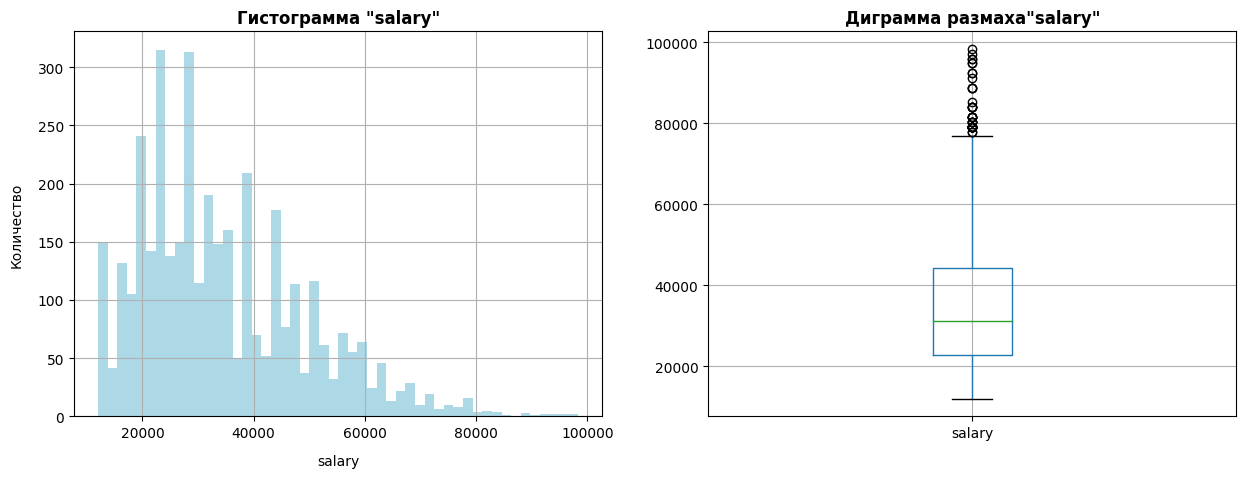

count     3755.000000
mean     34457.416778
std      15050.643870
min      12000.000000
25%      22800.000000
50%      31200.000000
75%      44400.000000
max      98400.000000
Name: salary, dtype: float64

In [17]:
quan_graphs(train_job_satisfaction_rate, 'salary')

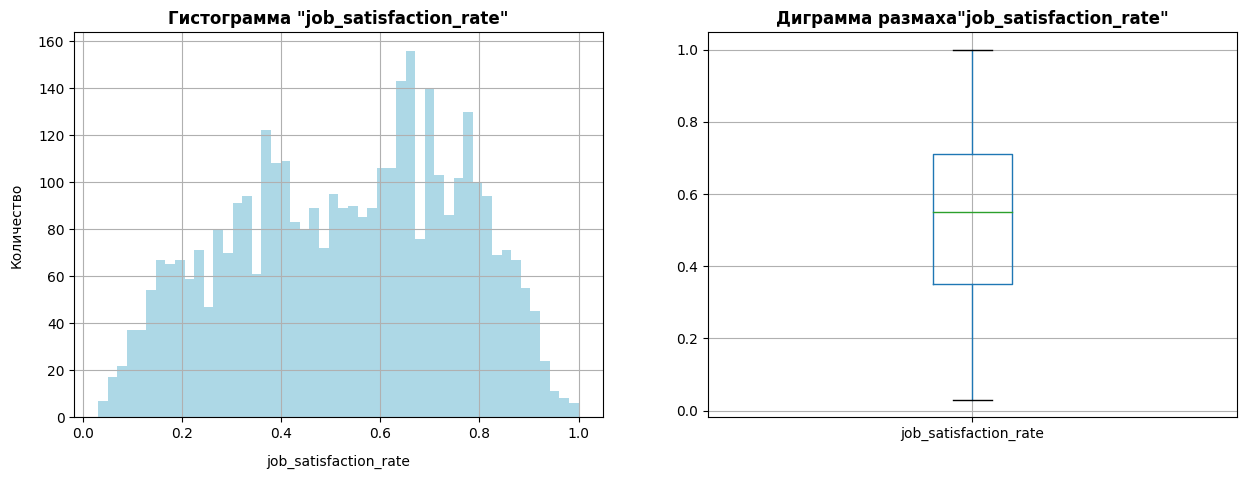

count    3755.000000
mean        0.532554
std         0.226393
min         0.030000
25%         0.350000
50%         0.550000
75%         0.710000
max         1.000000
Name: job_satisfaction_rate, dtype: float64

In [18]:
quan_graphs(train_job_satisfaction_rate, 'job_satisfaction_rate')

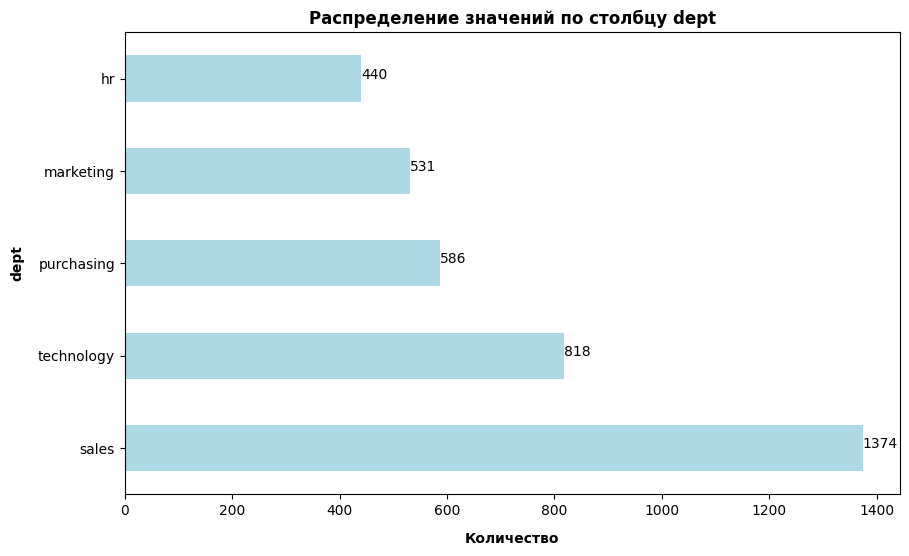

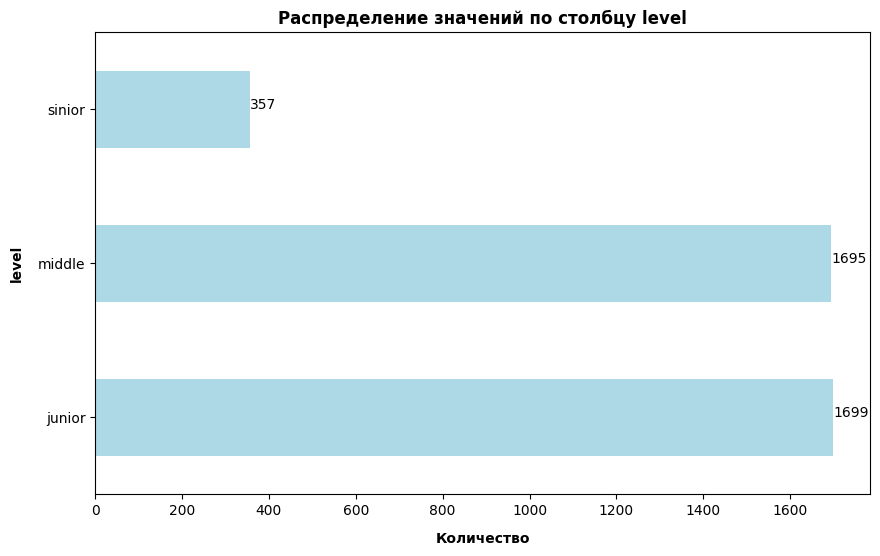

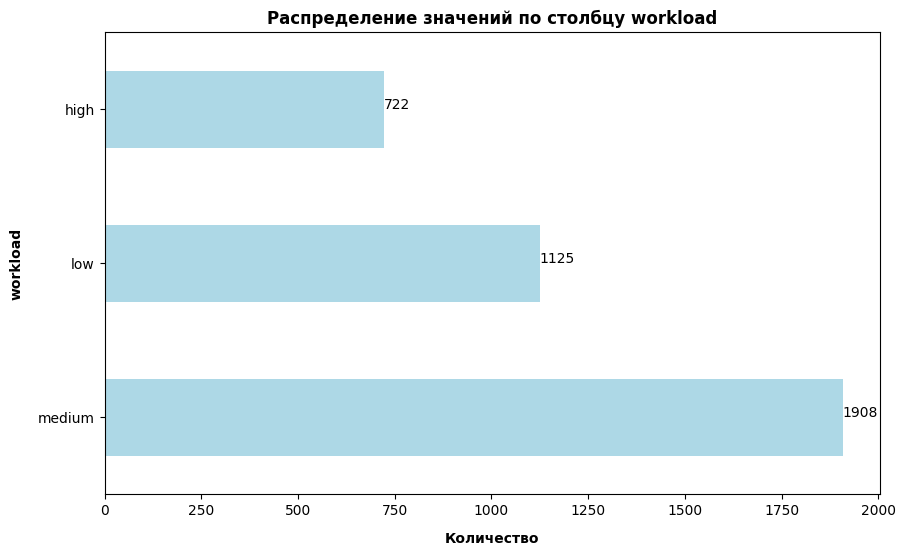

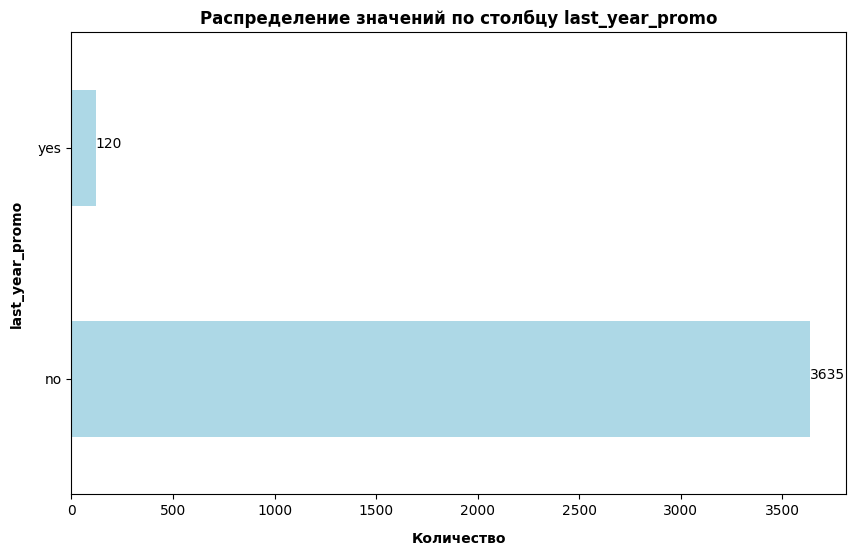

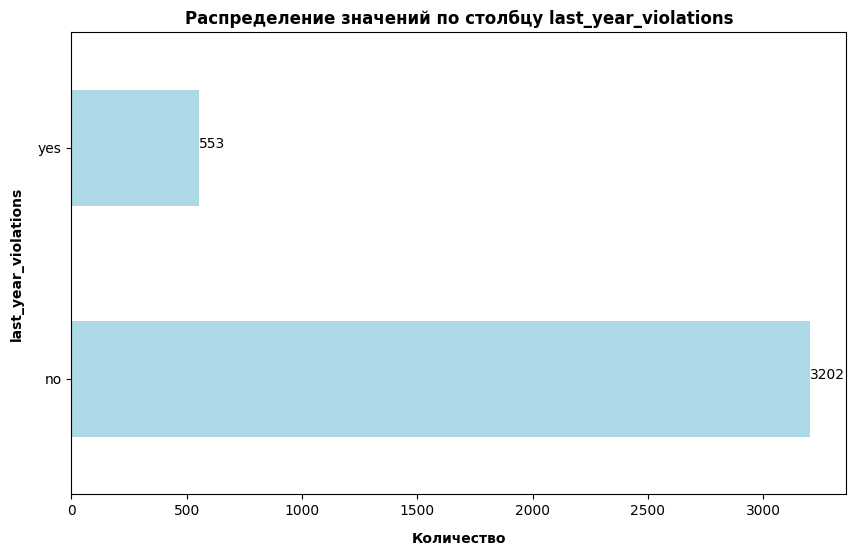

In [19]:
# Построим диаграммы для катеориальных признаков признаков
for i in train_job_satisfaction_rate.columns:
    if train_job_satisfaction_rate[i].dtype == 'object':
        сat_graphs(train_job_satisfaction_rate, i)

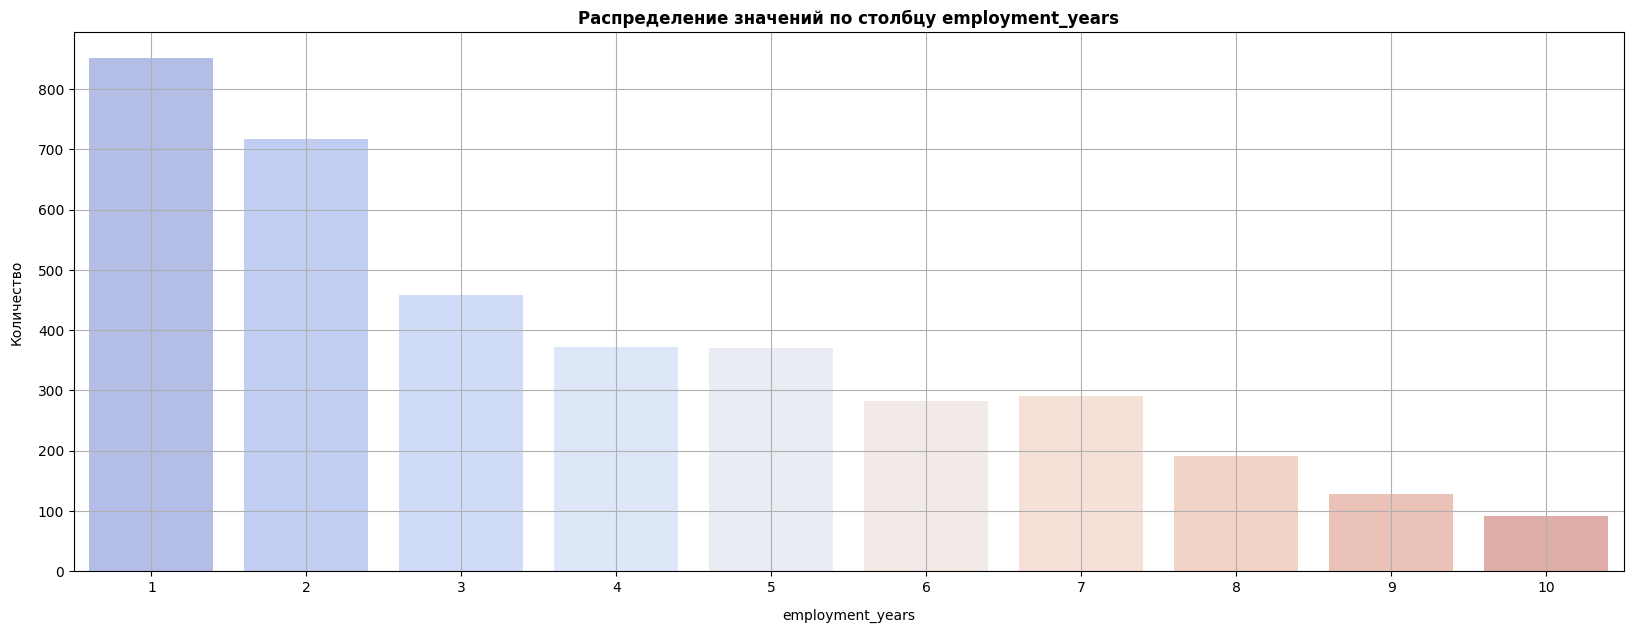

count    3755.000000
mean        3.817044
std         2.557142
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

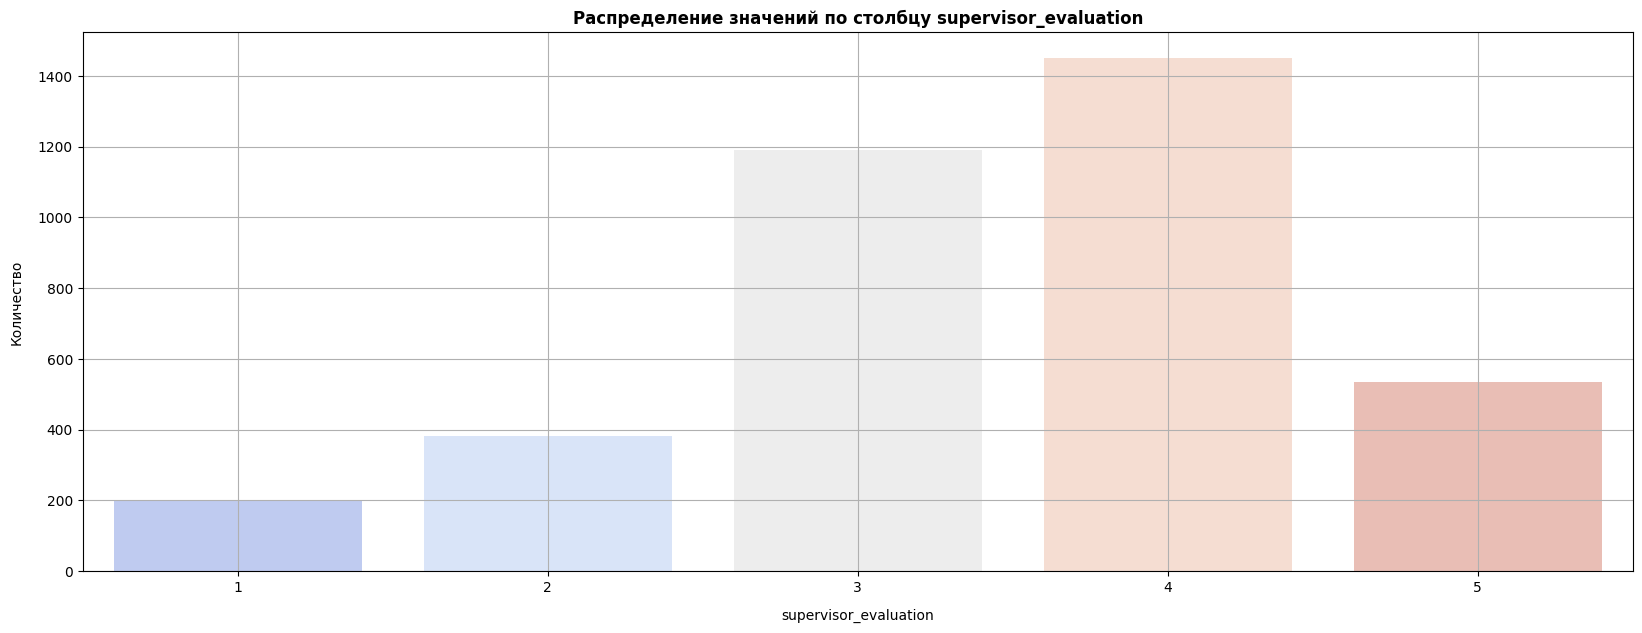

count    3755.000000
mean        3.463648
std         1.026265
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [20]:
# Построим диаграммы для дискретных признаков
for i in train_job_satisfaction_rate.columns:
    if train_job_satisfaction_rate[i].dtype != 'object' and i != 'salary' and i != 'job_satisfaction_rate':
        discrete_graphs(train_job_satisfaction_rate, i, None)

#### Тестовые данные

In [21]:
test_features = test_features.merge(test_target_job_satisfaction_rate, on='id')
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


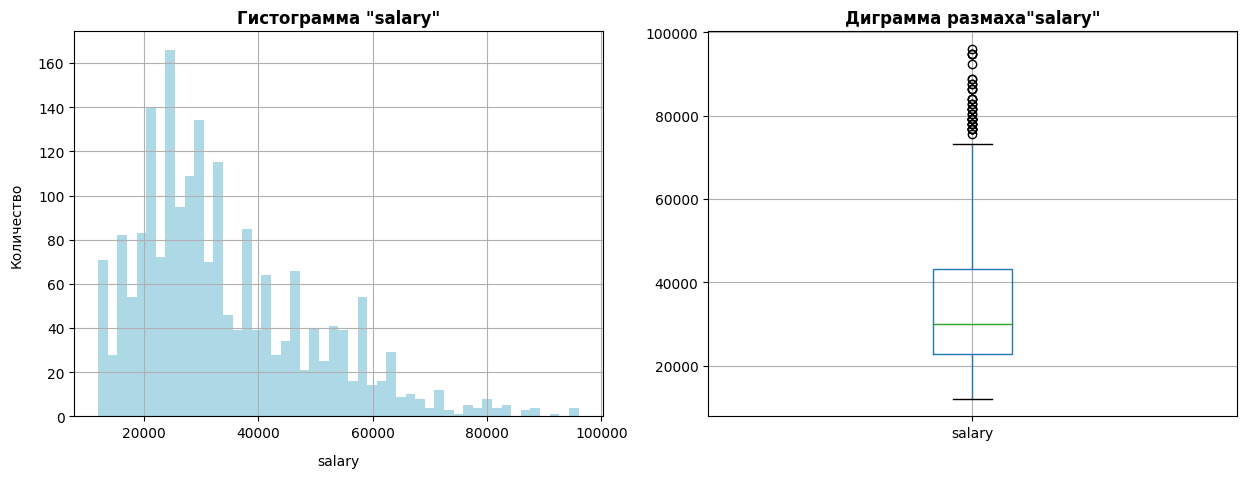

count     2000.000000
mean     34066.800000
std      15398.436729
min      12000.000000
25%      22800.000000
50%      30000.000000
75%      43200.000000
max      96000.000000
Name: salary, dtype: float64

In [22]:
quan_graphs(test_features, 'salary')

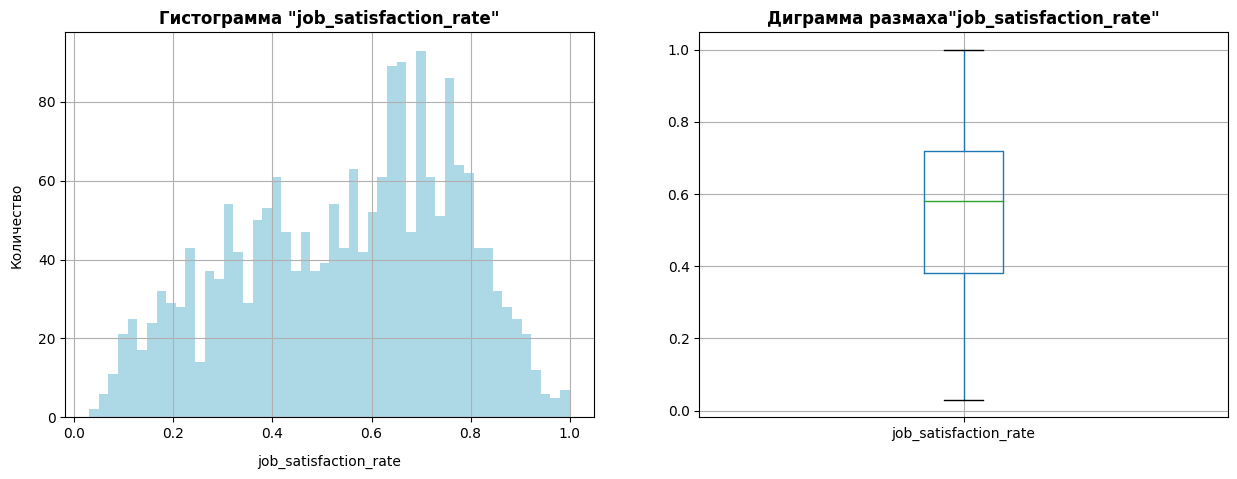

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

In [23]:
quan_graphs(test_features, 'job_satisfaction_rate')

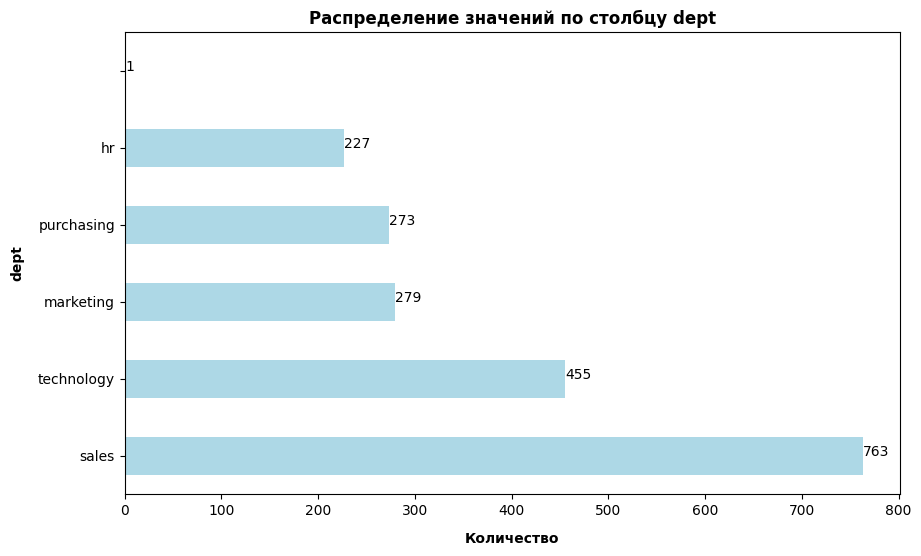

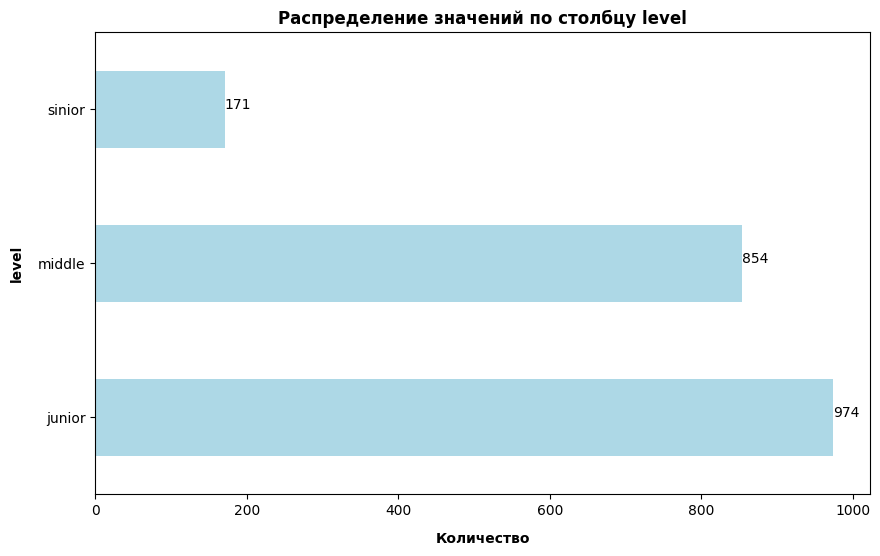

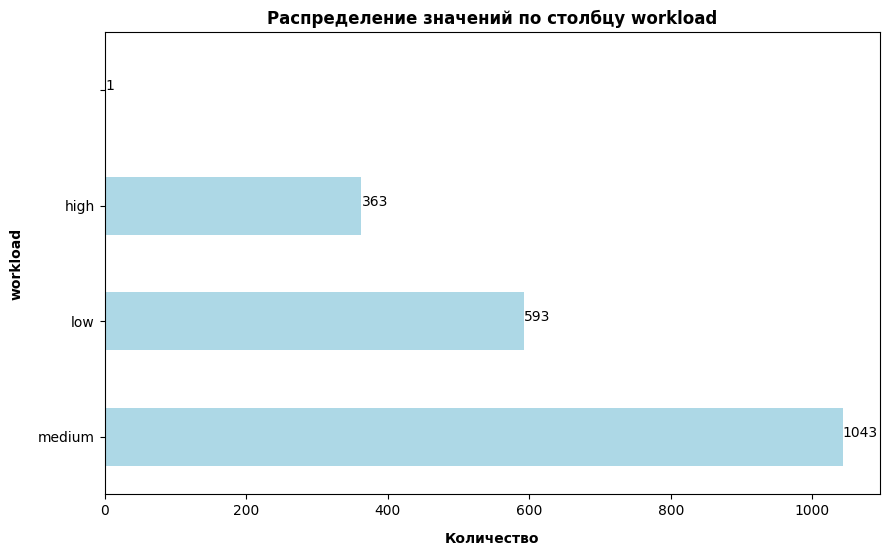

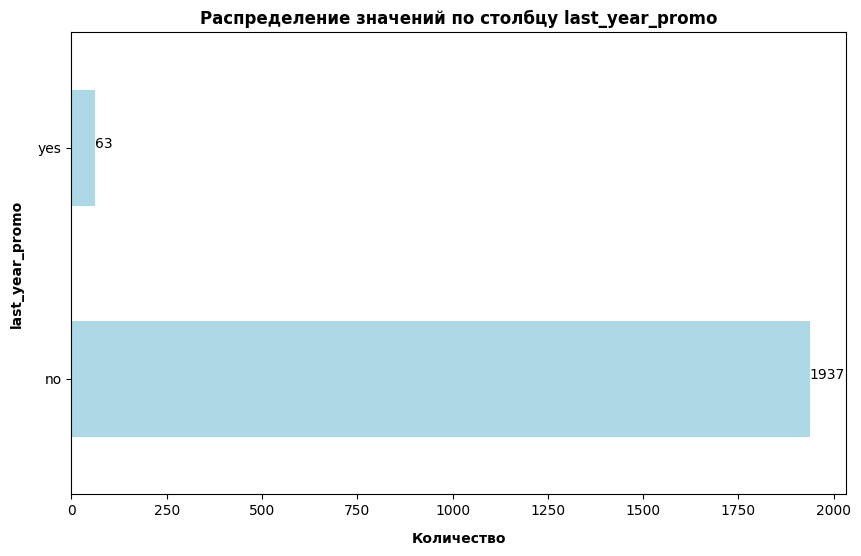

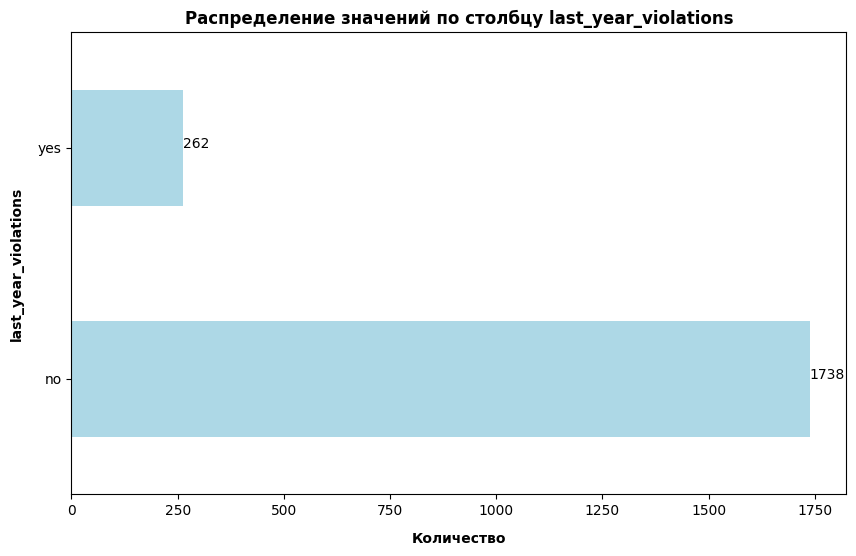

In [24]:
# Построим диаграммы для катеориальных признаков признаков
for i in test_features.columns:
    if test_features[i].dtype == 'object':
        сat_graphs(test_features, i)

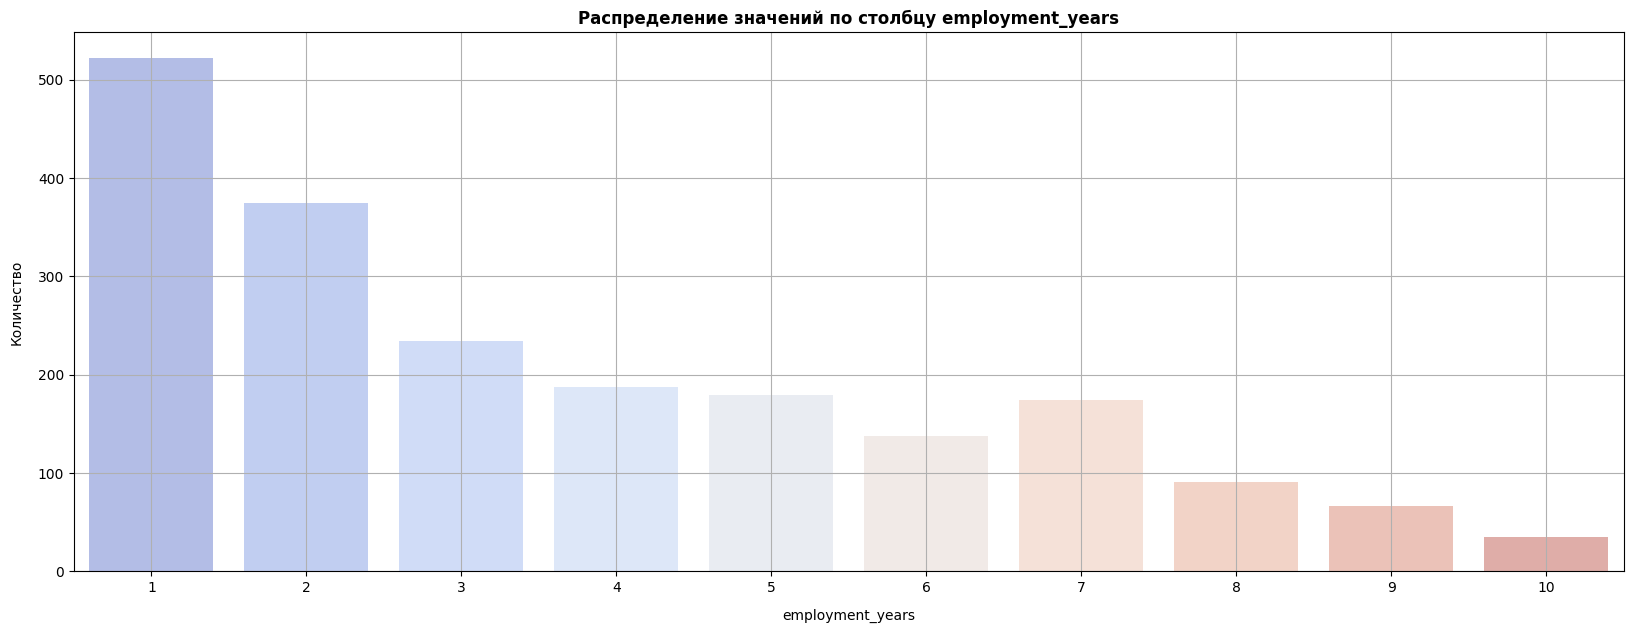

count    2000.000000
mean        3.666500
std         2.537222
min         1.000000
25%         1.000000
50%         3.000000
75%         6.000000
max        10.000000
Name: employment_years, dtype: float64

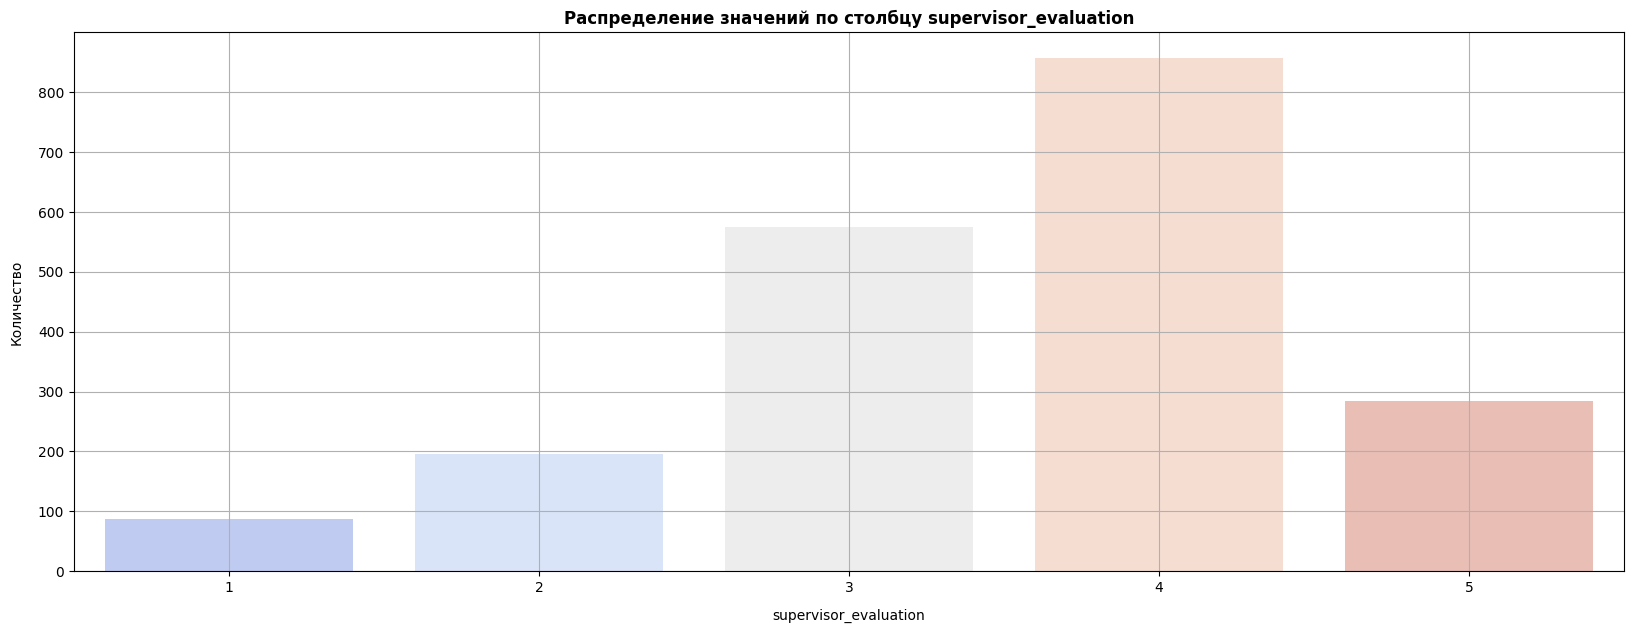

count    2000.000000
mean        3.526500
std         0.996892
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: supervisor_evaluation, dtype: float64

In [25]:
# Построим диаграммы для дискретных признаков
for i in test_features.columns:
    if test_features[i].dtype != 'object' and i != 'salary' and i != 'job_satisfaction_rate':
        discrete_graphs(test_features, i, None)

#### Вывод

- Минимальная ЗП составляет 12000, а максимальная 98400. У большинство сотрудников попадают в диапазон от 22800 до 44400. Есть  аномальные значения превышаюшие 79000
- Целевой признак `job_satisfaction_rate` (удовлетворенность) распределен нормально. Среднее значение 0.53. Выбросы отстутствуют.
- Большую нагрузку отметило - 722 сотрудника, а низкую - 1125. Возможно рабочая нагрузка распределена неравномерно.
- Стоит отметить достаточно большое количество сотрудников совершивших нараушения за год - 563, что состовляет ~ 14%.
- Около половины сотрудников работают в компании не более 3 лет. Сотрудников работающих один год ~ 850.
- Большинство сотрудников получили оценки 3 и 4 от руководителя.
- Тестовые данные похожи на обучающие, присутствуют неизвестные пустыe признаки в dept и workload - их обработаем в пайплайне.
    - у большинства сотрудников в тестовых данных ЗП попадает в диапозон 22800 - 43200
    - высокая нагрузку в тестовых данных отметили 22,60% сотрудников, в тренировочных - 23,80%.
    - число нарушений в  тестововых - 15,07%, а в тренировычных - 17,27%.

### Корреляционный анализ

In [26]:
interval_cols = ['salary', 
                 'job_satisfaction_rate']

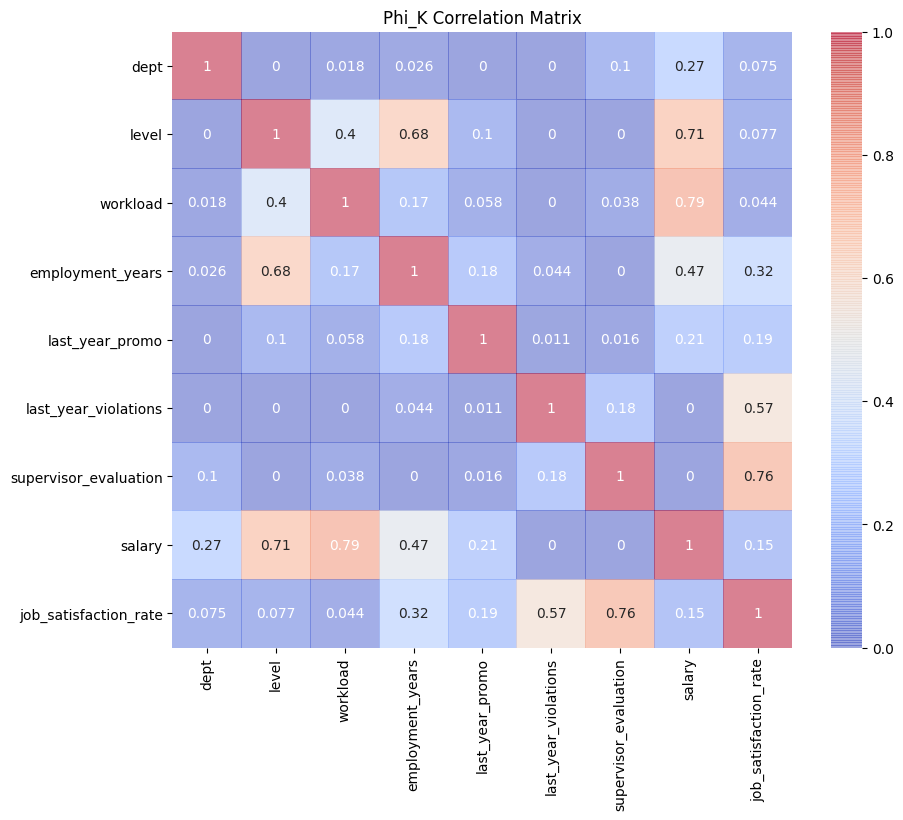

In [27]:
corr_matrix = train_job_satisfaction_rate.phik_matrix(interval_cols=interval_cols)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', alpha=0.5)
plt.title('Phi_K Correlation Matrix')
plt.show()

#### Вывод

На основании phik матрицы мультикоррелиарность между признаками отсутствует.

### Использование пайплайнов

In [28]:
test_features.shape

(2000, 9)

In [29]:
X_train = train_job_satisfaction_rate.drop(['job_satisfaction_rate'], axis=1)
y_train = train_job_satisfaction_rate['job_satisfaction_rate']
X_test = test_features.drop(['job_satisfaction_rate'], axis=1)
y_test = test_features['job_satisfaction_rate']

In [30]:
ohe_columns = ['dept', 'level']
ord_columns = ['workload', 'last_year_promo', 'last_year_violations']
num_columns = list(X_train.select_dtypes(include=[np.number]).columns.values)

num_columns

['employment_years', 'supervisor_evaluation', 'salary']

In [31]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [32]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['high', 'low', 'medium'],
                    ['no', 'yes'],
                    ['yes', 'no']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [33]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [34]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [35]:
param_grid = [   
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },  
    
    # словарь для модели LinearRegression()
    {
        'models' : [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 
    }
]

In [36]:
smape_score = make_scorer(score_func=smape, greater_is_better=False)

In [37]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_score,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [38]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'level']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_befo...
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 15),
                                         'models__max_features': range(2, 15),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [39]:
randomized_search.best_score_

-15.782505211576899

In [40]:
top_10_model = pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score').head(10)
top_10_model

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.032797,0.001328,0.012001,0.000893,StandardScaler(),14,14,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-15.047090,-15.365796,-15.973453,-17.186896,-15.339291,-15.782505,0.764159,1
1,0.044798,0.009327,0.019400,0.005816,passthrough,8,13,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-15.383460,-14.845949,-16.714227,-16.437928,-15.817377,-15.839788,0.681009,2
2,0.043600,0.012175,0.018801,0.006274,MinMaxScaler(),4,14,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-17.068504,-16.066278,-16.935802,-16.746314,-16.022372,-16.567854,0.439776,3
9,0.024400,0.001962,0.008202,0.001466,passthrough,13,10,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-16.405839,-15.588333,-17.062033,-17.655361,-16.364068,-16.615127,0.698992,4
0,0.037398,0.003498,0.021401,0.005713,StandardScaler(),6,14,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': StandardScaler(), 'model...",-16.885133,-15.483077,-17.212153,-17.111378,-17.069405,-16.752229,0.643355,5
4,0.027803,0.002486,0.010796,0.002397,passthrough,7,11,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-18.107047,-17.117108,-16.936345,-17.480832,-16.906034,-17.309473,0.448214,6
6,0.027000,0.004471,0.015203,0.000981,MinMaxScaler(),5,10,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-18.468851,-17.354209,-16.699625,-17.374527,-17.274139,-17.434270,0.573704,7
3,0.030599,0.002874,0.014401,0.001356,passthrough,3,13,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': 'passthrough', 'models__...",-19.174998,-16.926006,-19.877716,-17.588848,-19.277764,-18.569066,1.117358,8
7,0.026801,0.003060,0.014001,0.001416,MinMaxScaler(),14,3,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-23.269038,-21.992240,-23.706003,-22.693204,-21.867136,-22.705524,0.711383,9
5,0.020200,0.002711,0.010201,0.002400,MinMaxScaler(),7,3,DecisionTreeRegressor(random_state=42),"{'preprocessor__num': MinMaxScaler(), 'models_...",-23.870972,-22.403563,-24.317091,-24.460724,-23.296795,-23.669829,0.751998,10


In [41]:
y_test_pred = randomized_search.predict(X_test)
display(f'Лучшая модель: {randomized_search.best_estimator_["models"]}')
display(f'Метрика SMAPE на тестовой выборке: {smape(y_test, y_test_pred)}')

'Лучшая модель: DecisionTreeRegressor(max_depth=14, max_features=14, random_state=42)'

'Метрика SMAPE на тестовой выборке: 14.501315179855215'

#### Вывод

- Лучшая модель: DecisionTreeRegressor(max_depth=14, max_features=14, random_state=42)
- Метрика SMAPE на тестовой выборке: 14.5, что соответствует заданию - критерий успеха: SMAPE ≤ 15 на тестовой выборке.

## Задача 2. Предсказание увольнения сотрудника из компании

### Общая информация о датафреймах

In [42]:
dict_df = {'train_quit': train_quit, 
           'test_target_quit': test_target_quit}

In [43]:
for k, v in dict_df.items():
    display(HTML(f'<font color="navy"><b>Вывод информации о данных {k}</b></font>'))
    get_data_info(v)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


None

,count,mean,std,min,25%,50%,75%,max
employment_years,4000.0,3.70150,2.541852,1.0,2.0,3.0,6.0,10.0
supervisor_evaluation,4000.0,3.47475,1.004049,1.0,3.0,4.0,4.0,5.0
salary,4000.0,33805.80000,15152.415163,12000.0,22800.0,30000.0,43200.0,96000.0


dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

1413

,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


None

,count,unique,top,freq
quit,2000,2,no,1436


quit    0
dtype: int64

1998

#### Вывод

Выводы по загруженным данным:
    
Датафрейм `train_quit`:
- Описание столбцов соответствует содержимому;
- Типы данных соответствуют содержимому;
- Общее описание данных не вызывает вопросов;
- Cодержит 4000 строк;
- Пропуски отсутствуют;
- Явных дубликатов - 1413. Обучению модели они будут мешать - их удалим.

Датафрейм `test_target_quit`:
- Описание столбцов соответствует содержимому;
- Типы данных соответствуют содержимому;
- Общее описание данных не вызывает вопросов;
- Cодержит 2000 строк;
- Пропуски отсутствуют;

### Предобработка данных

#### Обработка явных дубликатов

In [44]:
train_quit = train_quit.drop_duplicates()
train_quit.shape

(2587, 9)

#### Обработка неявных дубликатов

In [45]:
# Выведим уникальные значения нечисловых столбцов датафреймов
for k, v in dict_df.items():
    display(HTML(f'<b>Уникальные нечисловые значения датафрейма {k}:</b>'))
    for i in v.columns:
        if v[i].dtype == 'object':
            display(HTML(f'Уникальные значения в столбце "<b>{i}</b>":'))
            display(pd.DataFrame(v[i].unique(), columns=["значения"]))
    display(HTML('<br>'))

,значения
0,sales
1,purchasing
2,marketing
3,technology
4,hr


,значения
0,middle
1,junior
2,sinior


,значения
0,high
1,medium
2,low


,значения
0,no
1,yes


,значения
0,no
1,yes


,значения
0,no
1,yes


,значения
0,yes
1,no


#### Вывод

Удалили 1413 дубликатов в `train_quit`. Неявные дубликаты необнаружены.

### Исследовательский анализ данных

#### Портрет «уволившегося сотрудника».

In [46]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


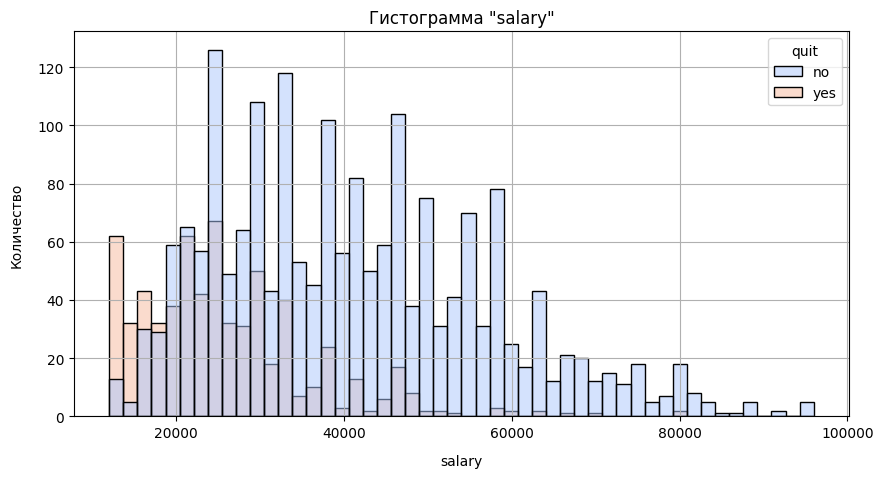

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,1932.0,40952.173913,16085.739667,12000.0,27600.0,39000.0,51600.0,96000.0
yes,655.0,25767.938931,10484.828614,12000.0,18000.0,24000.0,30600.0,79200.0


In [47]:
quan_graphs_target(train_quit, 'salary', 'quit')

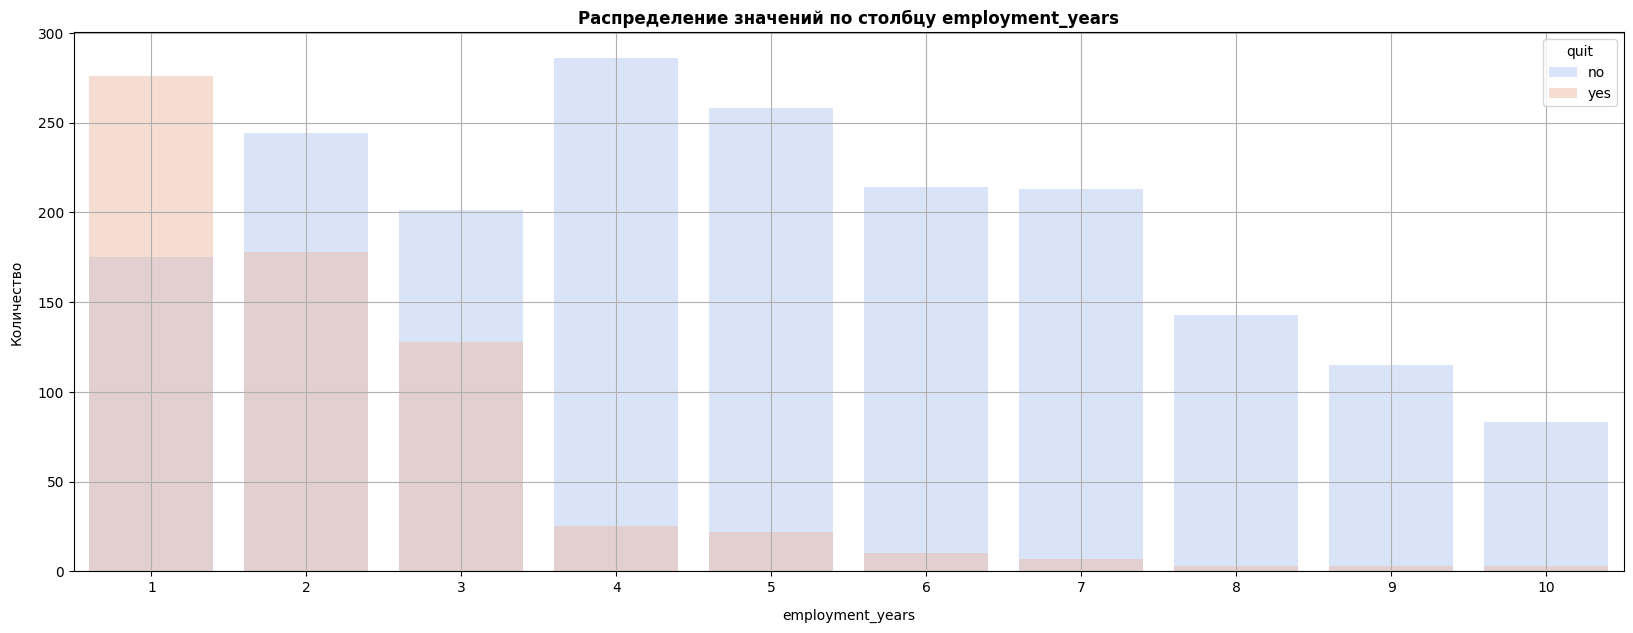

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,1932.0,4.908903,2.527730,1.0,3.0,5.0,7.0,10.0
yes,655.0,2.161832,1.497626,1.0,1.0,2.0,3.0,10.0


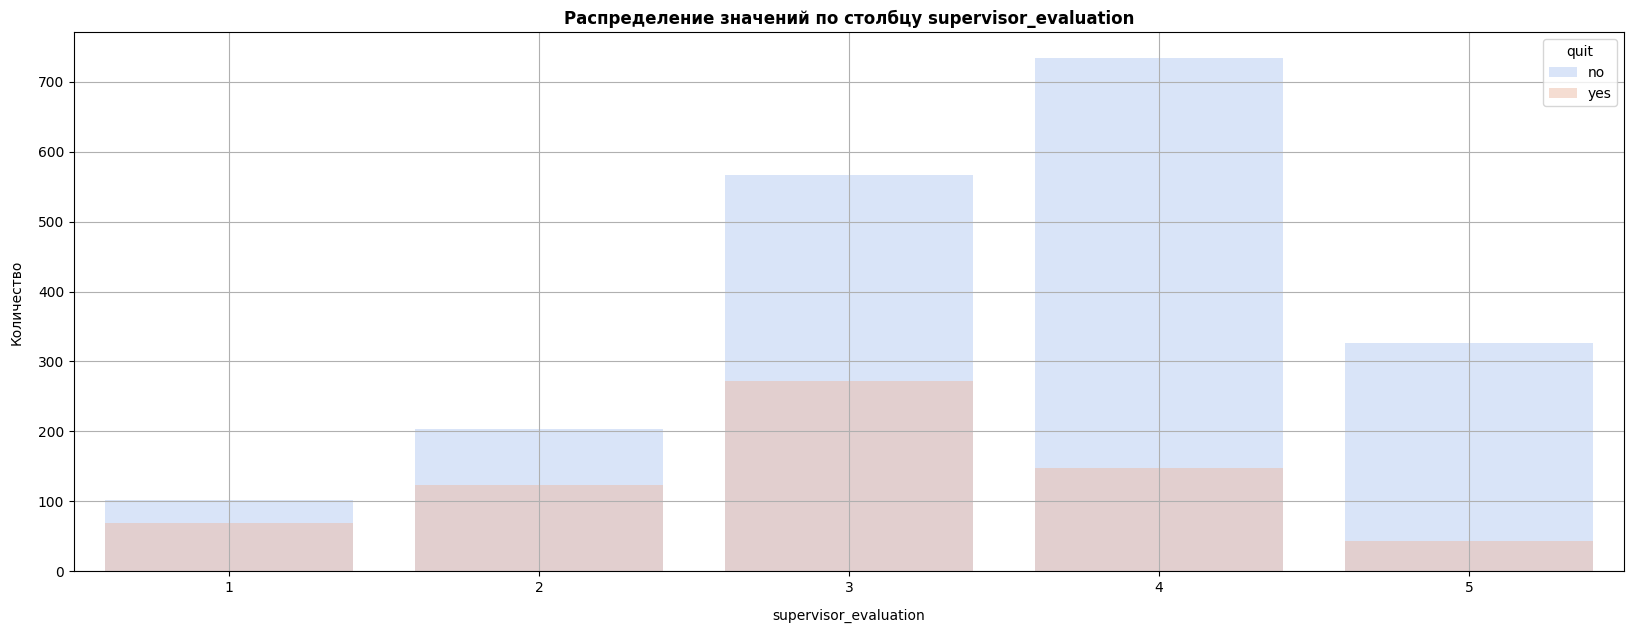

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,1932.0,3.506729,1.055898,1.0,3.0,4.0,4.0,5.0
yes,655.0,2.958779,1.047705,1.0,2.0,3.0,4.0,5.0


In [48]:
# Построим диаграммы для дискретных признаков
for i in train_quit.columns:
    if train_quit[i].dtype != 'object' and i != 'salary':
        discrete_graphs(train_quit, i, y='quit')

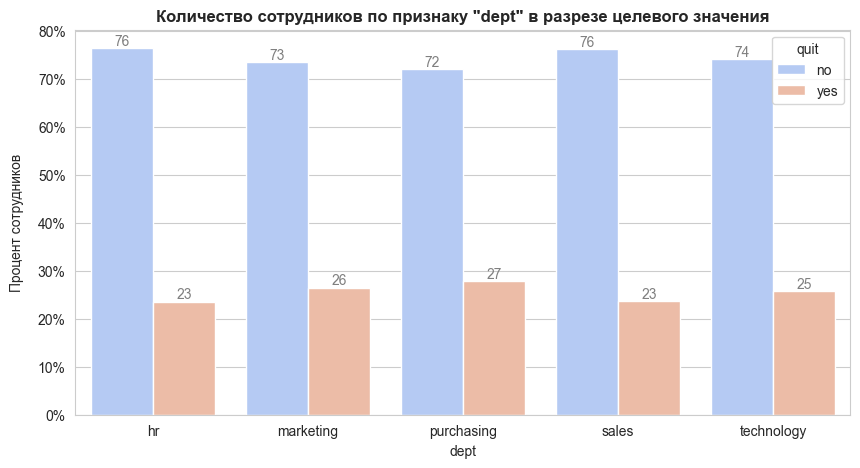

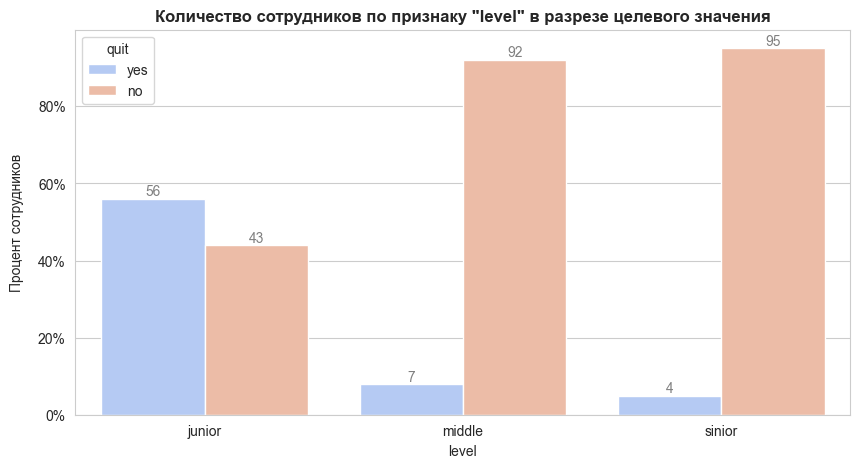

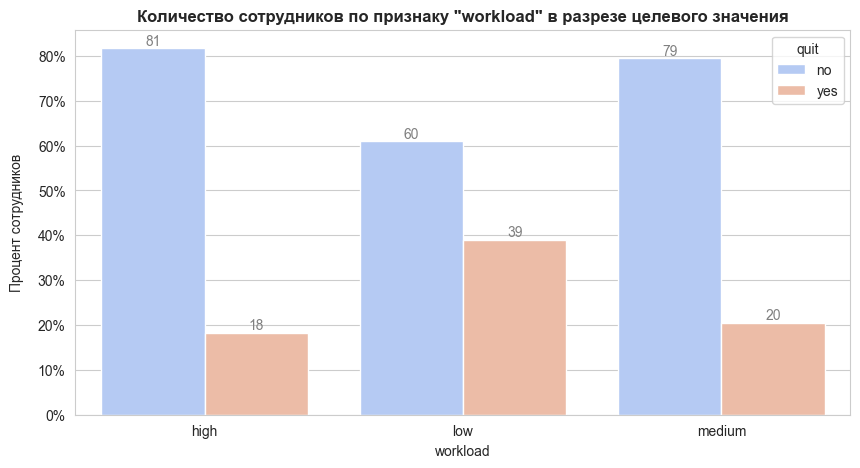

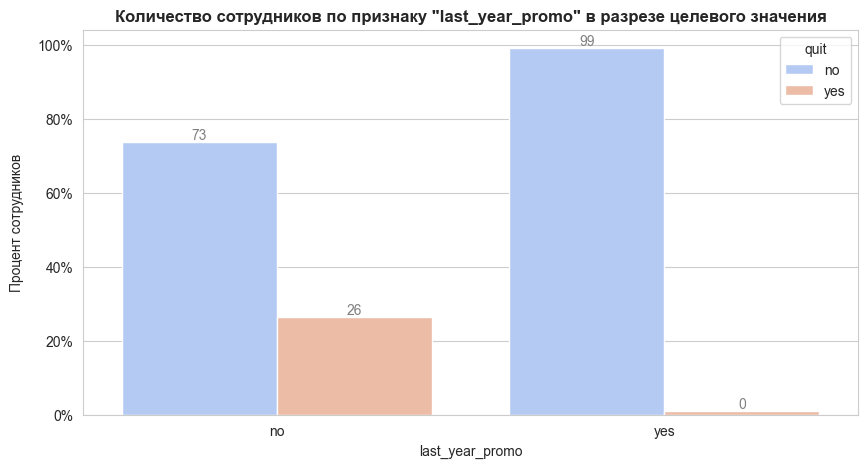

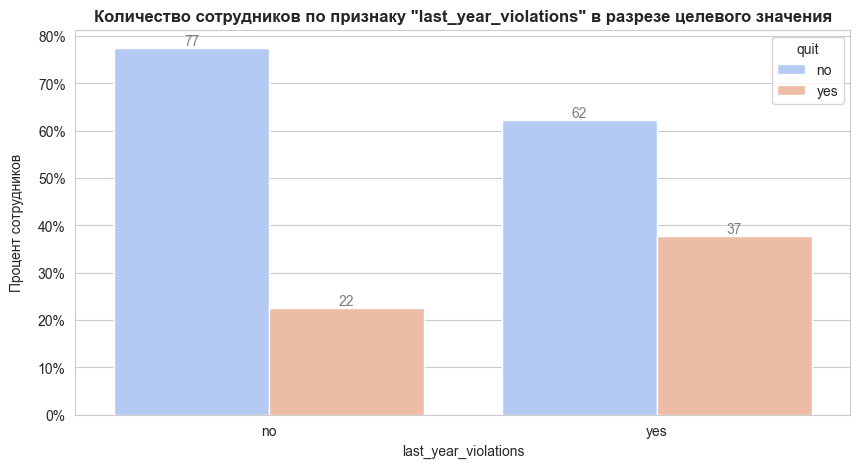

In [49]:
# Построим диаграммы для катеориальных признаков признаков
for i in train_quit.columns:
    if train_quit[i].dtype == 'object' and i != 'quit':
        сat_graphs_target(train_quit, i, 'quit')

- Сотрудники с меньшей зарплатной увольняются чаще. Средняя зарплата сотрудника покинувшего компанию - 25767.94, тогда как сотруднии оставшиеся получаеют в среднем - 40952.17.
- Покидают компанию, чаще всего в первые три года работы. В первый год количество уволенных превышает количество оставшихся в компании сотрудников.
- Количество уволенных джуниоров превышает количество оставшихся.

Предлагаю обратить внимание на программу адаптации и мотивацию новичков.

#### Влияние удовлетворенности на увольнение

In [50]:
train_quit.groupby('dept')['quit'].value_counts(normalize=True).rename('count').reset_index()

,dept,quit,count
0,hr,no,0.764368
1,hr,yes,0.235632
2,marketing,no,0.735225
3,marketing,yes,0.264775
4,purchasing,no,0.720930
5,purchasing,yes,0.279070
6,sales,no,0.762733
7,sales,yes,0.237267
8,technology,no,0.741824
9,technology,yes,0.258176


In [51]:
test_features = test_features.merge(test_target_quit, on='id')

In [52]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79,no
686555,hr,junior,medium,1,no,no,4,30000,0.72,no
467458,sales,middle,low,5,no,no,4,19200,0.64,no
418655,sales,middle,low,6,no,no,4,19200,0.60,no
789145,hr,middle,medium,5,no,no,5,40800,0.75,no


In [53]:
test_features.shape

(2000, 10)

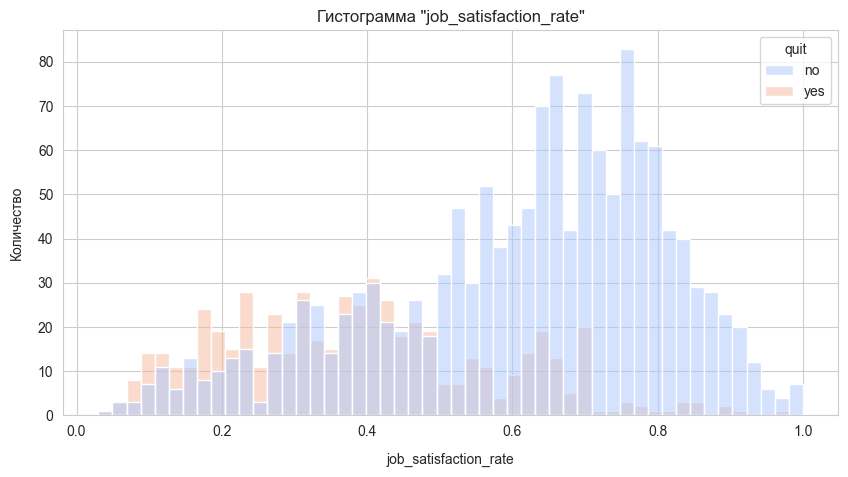

,count,mean,std,min,25%,50%,75%,max
quit,,,,,,,,
no,1436.0,0.612040,0.199367,0.03,0.50,0.66,0.7600,1.00
yes,564.0,0.387713,0.185784,0.04,0.24,0.37,0.4925,0.97


In [54]:
quan_graphs_target(test_features, 'job_satisfaction_rate', 'quit')

Удовлетворенность влияет на решение сотруника уволиться. По 75 процентилю значение удовлетворенности уволенных составляет - 0.49, а у продолжающих работу это показатель - 0.76.

#### Вывод

- Сотрудники с меньшей зарплатной увольняются чаще. Средняя зарплата сотрудника покинувшего компанию - 25767.94, тогда как сотруднии оставшиеся получаеют в среднем - 40952.17.
- Покидают компанию, чаще всего в первые три года работы. В первый год количество уволенных превышает количество оставшихся в компании сотрудников.
- Количество уволенных джуниоров превышает количество оставшихся.
- Удовлетворенность влияет на решение сотруника уволиться. По 75 процентилю значение удовлетворенности уволенных составляет - 0.49, а у продолжающих работу это показатель - 0.76.

Предлагаю обратить внимание на программу адаптации и мотивацию новичков. А в опрос добавить пункты позволяющие описать сотруднику, что послужило дать такую оценку, если оценка была ниже 0.5.

### Добавление нового входного признака

In [55]:
train_quit['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(train_quit)

In [56]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.638750
814010,sales,junior,medium,2,no,no,4,27600,no,0.853529
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.340000
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


In [57]:
test_features['job_satisfaction_rate'] = randomized_search.best_estimator_.predict(test_features)

In [58]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.863333,no
686555,hr,junior,medium,1,no,no,4,30000,0.678750,no
467458,sales,middle,low,5,no,no,4,19200,0.654000,no
418655,sales,middle,low,6,no,no,4,19200,0.655000,no
789145,hr,middle,medium,5,no,no,5,40800,0.816667,no


### Использование пайплайнов

In [59]:
X_train = train_quit.drop(['quit'], axis=1)
y_train = train_quit['quit']
X_test = test_features.drop(['quit'], axis=1)
y_test = test_features['quit']

In [60]:
#кодирование целевого признака
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [61]:
label_encoder.classes_

array(['no', 'yes'], dtype=object)

In [62]:
#ohe_columns = ['dept', 'level'] 
#ord_columns = ['workload', 'last_year_promo', 'last_year_violations']

num_columns = list(X_train.select_dtypes(include=[np.number]).columns.values)
num_columns

['employment_years',
 'supervisor_evaluation',
 'salary',
 'job_satisfaction_rate']

In [63]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

In [64]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
# SimpleImputer + OE
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['high', 'low', 'medium'],
                    ['no', 'yes'],
                    ['yes', 'no']
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [65]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [66]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [67]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 9),
        'models__max_features': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 9),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='poly', probability=True)],
        'models__degree': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [68]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [69]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'level']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_befo...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='poly',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__degree': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

randomized_search.best_score_

In [70]:
y_test_pred = randomized_search.predict_proba(X_test) 
display(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred[:, 1])}')

'Метрика ROC-AUC на тестовой выборке: 0.9151905657954523'

In [71]:
display(f'Лучшая модель: {randomized_search.best_estimator_["models"]}')

"Лучшая модель: LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear')"

In [72]:
top_10_model = pd.DataFrame(randomized_search.cv_results_).sort_values(by='rank_test_score').head(10)
top_10_model

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__num,param_models__max_features,param_models__max_depth,param_models,param_models__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.175794,0.008892,0.088005,0.004985,StandardScaler(),NaN,NaN,"LogisticRegression(penalty='l1', random_state=...",4.0,"{'preprocessor__num': StandardScaler(), 'model...",0.924818,0.907815,0.908150,0.892813,0.922695,0.911258,0.011631,1
2,0.129005,0.021768,0.083018,0.007477,MinMaxScaler(),6.0,5.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.879717,0.875762,0.894732,0.873453,0.887217,0.882176,0.007827,2
4,0.147217,0.005244,0.087201,0.008538,passthrough,4.0,7.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.867921,0.892745,0.876884,0.873087,0.896116,0.881351,0.011104,3
1,0.154996,0.002605,0.084188,0.004951,MinMaxScaler(),5.0,8.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.889777,0.897627,0.863080,0.852608,0.859154,0.872449,0.017846,4
0,0.153647,0.007338,0.090963,0.003600,StandardScaler(),3.0,4.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.872566,0.877725,0.871999,0.873186,0.853726,0.869840,0.008308,5
3,0.136772,0.006788,0.081429,0.004651,passthrough,7.0,8.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': 'passthrough', 'models__...",0.877478,0.902509,0.869972,0.846972,0.846191,0.868624,0.020978,6
9,0.135069,0.031706,0.049999,0.027868,StandardScaler(),5.0,2.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.813322,0.822376,0.848792,0.851709,0.822054,0.831651,0.015557,7
7,0.156172,0.005939,0.087893,0.010481,StandardScaler(),8.0,2.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.813322,0.822376,0.848792,0.851709,0.807717,0.828783,0.018165,8
6,0.152817,0.002149,0.088588,0.004319,StandardScaler(),7.0,2.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': StandardScaler(), 'model...",0.802257,0.808174,0.842394,0.839339,0.818683,0.822169,0.016176,9
8,0.148900,0.004853,0.095077,0.003557,MinMaxScaler(),7.0,2.0,DecisionTreeClassifier(random_state=42),NaN,"{'preprocessor__num': MinMaxScaler(), 'models_...",0.802257,0.808174,0.842394,0.839339,0.818683,0.822169,0.016176,9


#### Вывод

- Лучшая модель: LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear');
- Метрика ROC-AUC на тестовой выборке: 0.92, что соответствует заданию - ROC-AUC ≥ 0.91 на тестовой выборке.

## Вывод

**Предсказание уровня удовлетворённости сотрудника:**
- **Общая информация о датафреймах**
    
    Датафрейм `train_job_satisfaction_rate`:
    - Описание столбцов соответствует содержимому;
    - Типы данных соответствуют содержимому;
    - Общее описание данных не вызывает вопросов;
    - Cодержит 4000 строк;
    - Пропуски присутствуют:
        - dept - 6;
        - level - 4;
    - Явных дубликатов - 245. Обучению модели они будут мешать - их удалим.

    Датафрейм `test_features`:
    - Описание столбцов соответствует содержимому;
    - Типы данных соответствуют содержимому;
    - Общее описание данных не вызывает вопросов;
    - Cодержит 2000 строк;
    - Пропуски присутствуют:
        - dept - 2;
        - level - 1;
    - Явных дубликатов - 557.

    Датафрейм `test_target_job_satisfaction_rate`:
    - Описание столбцов соответствует содержимому;
    - Типы данных соответствуют содержимому;
    - Общее описание данных не вызывает вопросов;
    - Cодержит 2000 строк;
    - Пропуски отсутствуют.


- **Предобработка данных**
    
    Удалили 245 дубликатов в `train_job_satisfaction_rate`. Неявные дубликаты необнаружены.


- **Исследовательский анализ данных**

    - Минимальная ЗП составляет 12000, а максимальная 98400. У большинство сотрудников попадают в диапазон от 22800 до 44400. Есть  аномальные значения превышаюшие 79000
    - Целевой признак `job_satisfaction_rate` (удовлетворенность) распределен нормально. Среднее значение 0.53. Выбросы отстутствуют.
    - Большую нагрузку отметило - 722 сотрудника, а низкую - 1125. Возможно рабочая нагрузка распределена неравномерно.
    - Стоит отметить достаточно большое количество сотрудников совершивших нараушения за год - 563, что состовляет ~ 14%.
    - Около половины сотрудников работают в компании не более 3 лет. Сотрудников работающих один год ~ 850.
    - Большинство сотрудников получили оценки 3 и 4 от руководителя.
    - Тестовые данные похожи на обучающие, присутствуют неизвестные пустыe признаки в dept и workload - их обработаем в пайплайне.
        - у большинства сотрудников в тестовых данных ЗП попадает в диапозон 22800 - 43200
        - высокая нагрузку в тестовых данных отметили 22,60% сотрудников, в тренировочных - 23,80%.
        - число нарушений в  тестововых - 15,07%, а в тренировычных - 17,27%.


- **Обучение модели**

    - Лучшая модель: DecisionTreeRegressor(max_depth=14, max_features=14, random_state=42)
    - Метрика SMAPE на тестовой выборке: 14.5, что соответствует заданию - критерий успеха: SMAPE ≤ 15 на тестовой выборке.

**Предсказание увольнения сотрудника из компании**

- **Общая информация о датафреймах**

    Датафрейм `train_quit`:
    - Описание столбцов соответствует содержимому;
    - Типы данных соответствуют содержимому;
    - Общее описание данных не вызывает вопросов;
    - Cодержит 4000 строк;
    - Пропуски отсутствуют;
    - Явных дубликатов - 1413. Обучению модели они будут мешать - их удалим.

    Датафрейм `test_target_quit`:
    - Описание столбцов соответствует содержимому;
    - Типы данных соответствуют содержимому;
    - Общее описание данных не вызывает вопросов;
    - Cодержит 2000 строк;
    - Пропуски отсутствуют;


- **Предобработка данных**

    Удалили 1413 дубликатов в `train_quit`. Неявные дубликаты необнаружены.


- **Исследовательский анализ данных**

    - Сотрудники с меньшей зарплатной увольняются чаще. Средняя зарплата сотрудника покинувшего компанию - 25767.94, тогда как сотруднии оставшиеся получаеют в среднем - 40952.17.
    - Покидают компанию, чаще всего в первые три года работы. В первый год количество уволенных превышает количество оставшихся в компании сотрудников.
    - Количество уволенных джуниоров превышает количество оставшихся.
    - Удовлетворенность влияет на решение сотруника уволиться. По 75 процентилю значение удовлетворенности уволенных составляет - 0.49, а у продолжающих работу это показатель - 0.76.

    Предлагаю обратить внимание на программу адаптации и мотивацию новичков. А в опрос добавить пункты позволяющие описать сотруднику, что послужило дать такую оценку, если оценка была ниже 0.5.


- **Обучение модели**

    - Лучшая модель: LogisticRegression(C=4, penalty='l1', random_state=42, solver='liblinear');
    - Метрика ROC-AUC на тестовой выборке: 0.92, что соответствует заданию - ROC-AUC ≥ 0.91 на тестовой выборке.